# Testset Explorer

In [1]:
import sys
import os
import time
import random
import numpy as np
import copy
from datetime import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

from tqdm import tqdm
import config
from celeba_dataset import CelebaDataset, CelebaTestset
import models
from utils import Logger, AverageMeter, Bar, ModelTimer, savefig, adjust_learning_rate, accuracy, reset_gpu_cache, print_attribute_acc, create_dir_ifne, add_weight_decay

import seaborn as sns
sns.set()


# set the backend of matplotlib to the 'inline' backend
%matplotlib inline



In [2]:
# set random seed for reproducibility
def seed_everything(seed=None):
    if seed is None:
        seed = random.randint(1, 10000) # create random seed
        print(f'random seed used: {seed}')
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    if 'torch' in sys.modules:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
    
seed_everything(seed=config.manual_seed)

In [3]:
#files = os.path.join(config.TESTSET_DIR, '*\\*.jpg')
images = []
imagenames = []
celeba_names = []
celeba_ctr = {}
valid_images = [".jpg",".jpeg", ".gif",".png",".tiff"]
for dirname in os.listdir(config.TESTSET_DIR):
    dirpath = os.path.join(config.TESTSET_DIR, dirname)
    if os.path.isdir(dirpath):
        celeba_names.append(dirname)
        counter = 0
        for filename in os.listdir(dirpath):
            ext = os.path.splitext(filename)[1]
            if ext.lower() not in valid_images:
                continue
            images.append(os.path.join(dirpath, filename))
            imagenames.append(filename)
            counter += 1
        celeba_ctr[dirname] = counter
print(len(images), len(celeba_names))    
print(len(imagenames), len(celeba_names))  
print(images[0], imagenames[0])
#print(celeba_names[0])
#print(sorted(celeba_ctr))

13233 5749
13233 5749
../data/testset\Aaron_Eckhart\Aaron_Eckhart_0001.jpg Aaron_Eckhart_0001.jpg


In [4]:
a = sorted(celeba_ctr.items(), key=lambda x: x[1], reverse=True)    
print(a)

[('George_W_Bush', 530), ('Colin_Powell', 236), ('Tony_Blair', 144), ('Donald_Rumsfeld', 121), ('Gerhard_Schroeder', 109), ('Ariel_Sharon', 77), ('Hugo_Chavez', 71), ('Junichiro_Koizumi', 60), ('Jean_Chretien', 55), ('John_Ashcroft', 53), ('Jacques_Chirac', 52), ('Serena_Williams', 52), ('Vladimir_Putin', 49), ('Luiz_Inacio_Lula_da_Silva', 48), ('Gloria_Macapagal_Arroyo', 44), ('Arnold_Schwarzenegger', 42), ('Jennifer_Capriati', 42), ('Laura_Bush', 41), ('Lleyton_Hewitt', 41), ('Alejandro_Toledo', 39), ('Hans_Blix', 39), ('Nestor_Kirchner', 37), ('Andre_Agassi', 36), ('Alvaro_Uribe', 35), ('Megawati_Sukarnoputri', 33), ('Silvio_Berlusconi', 33), ('Tom_Ridge', 33), ('Kofi_Annan', 32), ('Roh_Moo-hyun', 32), ('Vicente_Fox', 32), ('David_Beckham', 31), ('John_Negroponte', 31), ('Guillermo_Coria', 30), ('Recep_Tayyip_Erdogan', 30), ('Bill_Clinton', 29), ('Mahmoud_Abbas', 29), ('Jack_Straw', 28), ('Juan_Carlos_Ferrero', 28), ('Ricardo_Lagos', 27), ('Gray_Davis', 26), ('Rudolph_Giuliani', 26)

In [5]:
img_dir = config.TESTSET_DIR
import glob
images = []
files = os.path.join(config.TESTSET_DIR, '*\\*.jpg')
print(files)
for filename in glob.glob(files):
    images.append(filename)
# print(images)
print(len(images))

../data/testset\*\*.jpg
13233


In [9]:
normalize_A = A.Normalize(mean=(0.485, 0.456, 0.406), 
                          std=(0.229, 0.224, 0.225))
test_transforms = A.Compose([
        #A.SmallestMaxSize(max_size=178),
        A.CenterCrop(height=218, width=158),
        normalize_A,
        ToTensorV2(),
    ]) 
test_transforms2 = A.Compose([
        #A.SmallestMaxSize(max_size=178),
        #A.CenterCrop(height=168, width=168),
        normalize_A,
        ToTensorV2(),
    ]) 

In [10]:
test_dataset = CelebaTestset(config.TESTSET_DIR, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.test_batch, 
                                         pin_memory=True, shuffle=False, num_workers=config.dl_workers)

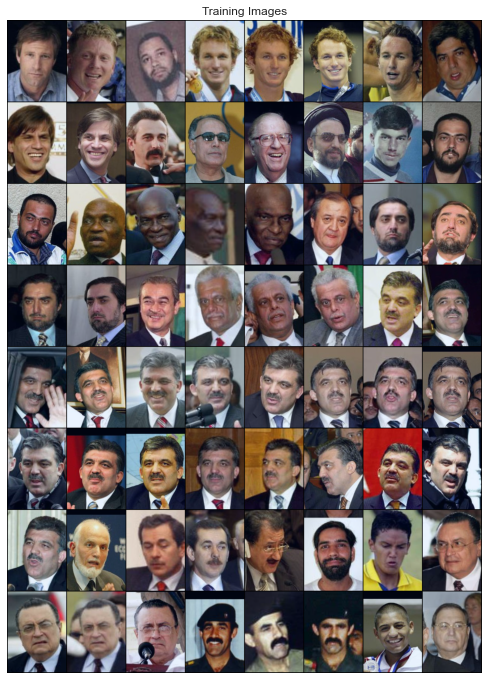

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
real_batch = next(iter(test_loader))
plt.figure(figsize=(12,12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def create_model(device):
    print("=> creating model '{}'".format(config.arch))
    if config.arch.startswith('FaceAttrResNet'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrResNeXt'):
        model = models.__dict__[config.arch](resnet_layers = config.pt_layers)
    elif config.arch.startswith('FaceAttrMobileNetV2'):
        model = models.__dict__[config.arch]()
    #print(model)
    model = model.to(device)
    return model
#print(model)
model = create_model(device)

In [ ]:
def resume_checkpoint(model, ckp_logger_fname, optimizer=None, ckp_resume=None):
    if not os.path.isdir(config.CHECKPOINT_DIR):
        try: 
            os.makedirs(config.CHECKPOINT_DIR)
        except OSError:
            raise
            
    start_epoch = 0
    best_prec1 = 0
    lr = config.lr

    if ckp_resume and os.path.isfile(ckp_resume): 
        print(f"=> resuming model: {ckp_resume}")
        optimizer, start_epoch, best_prec1, lr, total_train_time = model.load_ckp(optimizer, ckp_resume)
        model_timer = ModelTimer(total_train_time)
        if config.scheduler == 'Manual':
            lr = config.lr # self adjust from original
        config.checkpoint = os.path.dirname(ckp_resume)
        logger = Logger(ckp_logger_fname, title=model.name, resume=True)
    else:
        model_timer = ModelTimer()
        logger = Logger(ckp_logger_fname, title=model.name)
        logger.set_names(['Learning Rate', 'Train Loss', 'Valid Loss', 'Train Acc.', 'Valid Acc.'])
        
        
    return best_prec1, model_timer, lr, start_epoch, logger

best_prec1, mt, lr, start_epoch, logger = resume_checkpoint(model, config.ckp_logger_fname, None, config.bestmodel_fname)
print(best_prec1)

In [ ]:
attribute_names = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 
                       'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 
                       'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
                       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
                       'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
                       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 
                       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']

In [ ]:
preds = pd.DataFrame(index=test_dataset.imagenames, columns=attribute_names)
preds

In [ ]:
# preds.loc['Aaron_Eckhart_0001.jpg', :] = 0
# preds

In [ ]:
maxk = 1
model.eval()

for X, names in tqdm(test_loader, disable=False):
    #print(names)
    inputs = X.to(device, non_blocking=True)

    top_k_preds = []
    with torch.no_grad():
        outputs = model(inputs) # 40, BS
    
        for attr_scores in outputs:
            _, attr_preds = attr_scores.topk(maxk, 1, True, True)
            top_k_preds.append(attr_preds.t())
            
    all_preds = torch.cat(top_k_preds, dim=0) 
    #print(all_preds.shape)
    all_preds = all_preds.permute(1,0).cpu()
    all_preds[all_preds == 0] = -1
    for j in range(len(names)):
        preds.loc[names[j], :] = all_preds[j]
    
    #preds.append(outputs.numpy())
preds

In [ ]:
stat_df = pd.DataFrame(index = attribute_names)
stat_df.loc[:,'Testset'] = (preds.iloc[:,:] == 1).mean(axis=0)*100
stat_df = stat_df.sort_values('Testset', ascending=False)
stat_df.plot(title='CelebA Private Testset Prediction Frequency Distribution', 
             kind='bar', figsize=(20, 5))
print(preds[(preds['Young']==1) & (preds['Gray_Hair']==1)].index)
print(preds[(preds['Male']==-1) & (preds['Mustache']==1)].index)
print(preds[(preds['Male']==-1) & (preds['Goatee']==1)].index)
print(preds[(preds['Gray_Hair']==1) & (preds['Blond_Hair']==1)].index)
print(preds[(preds['Male']==-1) & (preds['No_Beard']==-1)].index)

In [ ]:
celeb_preds = preds[preds.index.str.contains('George_W_Bush')]
celeb_stat = pd.DataFrame(index = attribute_names)
celeb_stat.loc[:,'George_W_Bush'] = (celeb_preds.iloc[:,:] == 1).mean(axis=0)*100
celeb_stat = celeb_stat.sort_values('George_W_Bush', ascending=False)
celeb_stat.plot(title='CelebA George_W_Bush Prediction Frequency Distribution', 
             kind='bar', figsize=(20, 5))
celeb_preds[(celeb_preds['Young']==1) & (celeb_preds['Gray_Hair']==1)].index
celeb_preds[(celeb_preds['Male']==0) & (celeb_preds['Mustache']==1)].index

In [ ]:
def plot_prediction_with_image(preds, index):
    p_attrs = preds.iloc[index,:]
    p_img = preds.index[index]
    fig, (ax, ax2) = plt.subplots(ncols=2)
    p_attrs.plot(kind='barh',ax=ax, figsize=(12, 8))
    s_img = test_dataset[index][0].permute(1, 2, 0)
    ax2.imshow(s_img)
    ax2.set_axis_off()
    plt.title(p_img)
    plt.show()
    
plot_prediction_with_image(preds, 0)

In [ ]:
plot_prediction_with_image(preds, -5)

In [ ]:
plot_prediction_with_image(preds, 3)

In [ ]:
preds.to_csv('submission.csv', index=True)